In [1]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("zlatan599/mushroom1")

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

In [26]:
from keras import Sequential, Input, layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

In [3]:
train = pd.read_csv('/kaggle/input/mushroom1/train.csv')
test = pd.read_csv('/kaggle/input/mushroom1/test.csv')
val = pd.read_csv('/kaggle/input/mushroom1/val.csv')

update paths in the csv

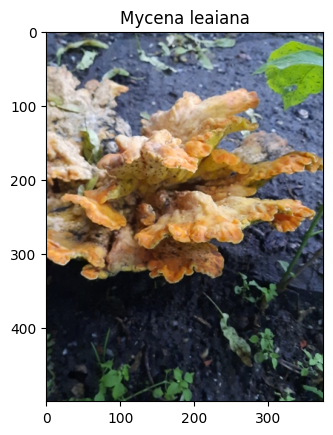

In [4]:
BASE_PATH = "/kaggle/input/mushroom1/merged_dataset"


# Replace Kaggle path with Colab base path
train["image_path"] = train["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)
test["image_path"] = test["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)
val["image_path"] = val["image_path"].str.replace(
    "/kaggle/working/merged_dataset", BASE_PATH
)


img_path = train["image_path"].iloc[50]

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.title(train["label"].iloc[5])
plt.show()

check images sizes

In [5]:
shapes = []
for path in train["image_path"].sample(500):
    with Image.open(path) as img:
        shapes.append(img.size)
sizes = pd.Series(shapes)
print(sizes.value_counts().head(15))

(640, 480)    106
(375, 500)     85
(500, 375)     65
(500, 333)     38
(480, 640)     18
(281, 500)     12
(640, 426)      8
(640, 360)      8
(333, 500)      7
(640, 427)      6
(360, 640)      6
(500, 281)      6
(500, 500)      5
(225, 500)      4
(640, 425)      4
Name: count, dtype: int64


Find duplicates inside train df and show the first few duplicates


In [6]:
dup_paths = train["image_path"][train["image_path"].duplicated()]
print("Number of duplicate image paths in train:", dup_paths.shape[0])
print(dup_paths.head(10))

Number of duplicate image paths in train: 616662
72858    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72859    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72860    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72861    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72862    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72863    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72864    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72865    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72866    /kaggle/input/mushroom1/merged_dataset/Agaricu...
72867    /kaggle/input/mushroom1/merged_dataset/Agaricu...
Name: image_path, dtype: object


### drop duplicates

In [7]:
print("Before removing duplicates:", train.shape)
train_df_unique = train.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", train_df_unique.shape)

Before removing duplicates: (689520, 2)
After  removing duplicates: (72858, 2)


In [8]:
print("Before removing duplicates:", test.shape)
test_df_unique = test.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", test_df_unique.shape)

Before removing duplicates: (15614, 2)
After  removing duplicates: (15614, 2)


In [9]:
print("Before removing duplicates:", val.shape)
val_df_unique = val.drop_duplicates(subset="image_path", keep="first").reset_index(drop=True)
print("After  removing duplicates:", val_df_unique.shape)

Before removing duplicates: (15616, 2)
After  removing duplicates: (15616, 2)


### Count how many images per species

In [11]:
train_counts = train["label"].value_counts()

print("Number of species in train:", train_counts.shape[0])
print("\nTop 10 most common species:\n", train_counts.head(10))
print("\nBottom 10 least common species:\n", train_counts.tail(10))

Number of species in train: 169

Top 10 most common species:
 label
Lycoperdon perlatum            4080
Chlorociboria aeruginascens    4080
Amanita muscaria               4080
Xanthoria parietina            4080
Coprinellus micaceus           4080
Mycena leaiana                 4080
Suillus luteus                 4080
Gyromitra gigas                4080
Laetiporus sulphureus          4080
Fomitopsis pinicola            4080
Name: count, dtype: int64

Bottom 10 least common species:
 label
Tylopilus rubrobrunneus      4080
Fomitopsis mounceae          4080
Stereum hirsutum             4080
Peltigera aphthosa           4080
Cantharellus cinnabarinus    4080
Agaricus augustus            4080
Mutinus ravenelii            4080
Trametes betulina            4080
Gymnopilus luteofolius       4080
Coprinopsis atramentaria     4080
Name: count, dtype: int64

Stats on class counts:
count     169.0
mean     4080.0
std         0.0
min      4080.0
25%      4080.0
50%      4080.0
75%      4080.0
max 

### data preprocessing

ImageDataGenerator:class from tensorflow.keras.preprocessing.image to automatically rescale, augment, and normalize image data and efficiently load batches of images from dataframe during training.

### baseline model

In [19]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)
num_classes = len(train_gen.class_indices)
model = Sequential([
    Input(shape=(224, 224, 3)),     # accept any image size
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_classification_v1.keras")
files.download("mushroom_classification_v1.keras")

### same baseline model but added GlobalAveragePooling2D + Regularization (L2) (to reduce overfitting)

In [16]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=False
)
num_classes = len(train_gen.class_indices)
model = Sequential([
    Input(shape=(224, 224, 3)),     # accept any image size
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_classification_v2.keras")
files.download('mushroom_classification_v2.keras')

NameError: name 'ImageDataGenerator' is not defined

### Transfer Learning: using **MobileNetV2** as abase model with some image generation

In [18]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
)

train_gen = datagen.flow_from_dataframe(
    train_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=True
)
val_gen = datagen.flow_from_dataframe(
    val_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df_unique, x_col="image_path", y_col="label",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)


base = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first


num_classes = len(train_gen.class_indices)
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_mnv2_model3.keras")
files.download('mushroom_mnv2_model3.keras')

Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 169)            │       216,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,474,473 (9.44 MB)

 Trainable params: 216,489 (845.66 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1854s 803ms/step - accuracy: 0.3990 - loss: 2.7283 - val_accuracy: 0.5873 - val_loss: 1.6158
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1166s 512ms/step - accuracy: 0.5655 - loss: 1.6828 - val_accuracy: 0.6091 - val_loss: 1.5196
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1172s 515ms/step - accuracy: 0.5912 - loss: 1.5700 - val_accuracy: 0.6148 - val_loss: 1.5019
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1167s 513ms/step - accuracy: 0.6020 - loss: 1.5270 - val_accuracy: 0.6254 - val_loss: 1.4840
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1165s 512ms/step - accuracy: 0.6050 - loss: 1.5279 - val_accuracy: 0.6237 - val_loss: 1.4837
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1166s 512ms/step - accuracy: 0.6176 - loss: 1.4877 - val_accuracy: 0.6248 - val_loss: 1.4780
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1162s 510ms/step - accuracy: 0.6105 - loss: 1.5179 - val_accuracy: 0.6276 - val_loss: 1.4982
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 1161s 510ms/s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transfer Learning: using **MobileNetV2** as a base model

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

base = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first


num_classes = len(train_gen.class_indices)
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
es = [EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,
    verbose=1,
    callbacks=es
)
model.evaluate(test_gen, verbose=1)
model.save("mushroom_mnv2_model4.keras")
files.download('mushroom_mnv2_model4.keras')


### Transfer Learning: using **EfficientNetV2-B0** as a base model

In [51]:
import time

start_time = time.time()

train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)

base = EfficientNetV2B0(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first

model_EfficientNetV2B0_base = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')])

model_EfficientNetV2B0_base.compile(optimizer = Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

cbs = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("mushroom_efficientnetv2b0_best.keras", save_best_only=True, monitor="val_accuracy"),
]

history = model_EfficientNetV2B0_base.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    verbose=1,
    callbacks=es
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time / 60:.2f} minutes")

model_EfficientNetV2B0_base.evaluate(test_gen, verbose=1)
model_EfficientNetV2B0_base.save("mushroom_model_EfficientNetV2B0_4.keras")
files.download('mushroom_model_EfficientNetV2B0_4.keras')


Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 397s 165ms/step - accuracy: 0.2160 - loss: 3.9356 - val_accuracy: 0.4608 - val_loss: 2.4434
Epoch 2/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 364s 160ms/step - accuracy: 0.4755 - loss: 2.3291 - val_accuracy: 0.5610 - val_loss: 1.9070
Epoch 3/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 353s 155ms/step - accuracy: 0.5642 - loss: 1.8799 - val_accuracy: 0.6184 - val_loss: 1.6425
Epoch 4/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 357s 157ms/step - accuracy: 0.6067 - loss: 1.6512 - val_accuracy: 0.6493 - val_loss: 1.4818
Epoch 5/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 355s 156ms/step - accuracy: 0.6391 - loss: 1.4981 - val_accuracy: 0.6728 - val_loss: 1.3739
Epoch 6/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 362s 159ms/step - accuracy: 0.6596 - loss: 1.3884 - val_accuracy: 0.6856 - val_loss: 1.2957
Epoch 7/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 358s 157ms/step - accuracy: 0.6746 - loss: 1.3134 - val_accuracy: 0.6961 - val_loss: 1.2363
Epoch 8/8
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 361s 159ms/step - accuracy: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 169)            │        43,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,046,893 (38.33 MB)

 Trainable params: 1,648,473 (6.29 MB)

 Non-trainable params: 5,101,472 (19.46 MB)

 Optimizer params: 3,296,948 (12.58 MB)

In [52]:
model.evaluate(test_gen, verbose=1)


488/488 ━━━━━━━━━━━━━━━━━━━━ 74s 151ms/step - accuracy: 0.4068 - loss: 2.8581


[2.845329999923706, 0.40879979729652405]

### Transfer Learning: using **EfficientNetV2-B0** as a base model - second try

In [53]:
import time

start_time = time.time()
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)

base = EfficientNetV2B0(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first

model_EfficientNetV2B0_base2 = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')])

model_EfficientNetV2B0_base2.compile(optimizer = Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

cbs = [
    EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    ModelCheckpoint("mushroom_efficientnetv2b0_best.keras", save_best_only=True, monitor="val_accuracy"),
]

history = model_EfficientNetV2B0_base2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=cbs
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time / 60:.2f} minutes")

model_EfficientNetV2B0_base2.evaluate(test_gen, verbose=1)
model_EfficientNetV2B0_base2.save("mushroom_model_EfficientNetV2B0_6.keras")
files.download('mushroom_model_EfficientNetV2B0_6.keras')

Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 394s 163ms/step - accuracy: 0.4654 - loss: 2.4152 - val_accuracy: 0.7020 - val_loss: 1.1672
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 351s 154ms/step - accuracy: 0.6854 - loss: 1.1833 - val_accuracy: 0.7366 - val_loss: 1.0054
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 355s 156ms/step - accuracy: 0.7250 - loss: 1.0102 - val_accuracy: 0.7479 - val_loss: 0.9393
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 355s 156ms/step - accuracy: 0.7385 - loss: 0.9323 - val_accuracy: 0.7542 - val_loss: 0.9006
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 348s 153ms/step - accuracy: 0.7528 - loss: 0.8753 - val_accuracy: 0.7617 - val_loss: 0.8781
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 353s 155ms/step - accuracy: 0.7599 - loss: 0.8366 - val_accuracy: 0.7704 - val_loss: 0.8594
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 347s 152ms/step - accuracy: 0.7649 - loss: 0.8170 - val_accuracy: 0.7681 - val_loss: 0.8540
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 352s 154ms/step - ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
model_EfficientNetV2B0_base2.evaluate(test_gen, verbose=1)


488/488 ━━━━━━━━━━━━━━━━━━━━ 62s 127ms/step - accuracy: 0.7587 - loss: 0.8579


[0.8532677888870239, 0.762264609336853]

488/488 ━━━━━━━━━━━━━━━━━━━━ 63s 130ms/step
[[ 15   0   0 ...   0   0   0]
 [  3  13   0 ...   0   0   0]
 [  0   0   8 ...   0   0   0]
 ...
 [  0   3   0 ...   5   0   0]
 [  0   0   0 ...   0  70  39]
 [  0   0   0 ...   0  16 823]]
              precision    recall  f1-score   support

           0       0.41      0.29      0.34        51
           1       0.41      0.28      0.33        46
           2       0.73      0.16      0.26        50
           3       0.50      0.26      0.34        50
           4       0.39      0.54      0.45        46
           5       0.60      0.63      0.61        49
           6       0.52      0.64      0.57        44
           7       0.68      0.35      0.47        48
           8       0.85      0.96      0.90       687
           9       0.62      0.29      0.40        51
          10       0.43      0.08      0.13        39
          11       0.41      0.27      0.33        48
          12       0.54      0.35      0.43        79
       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


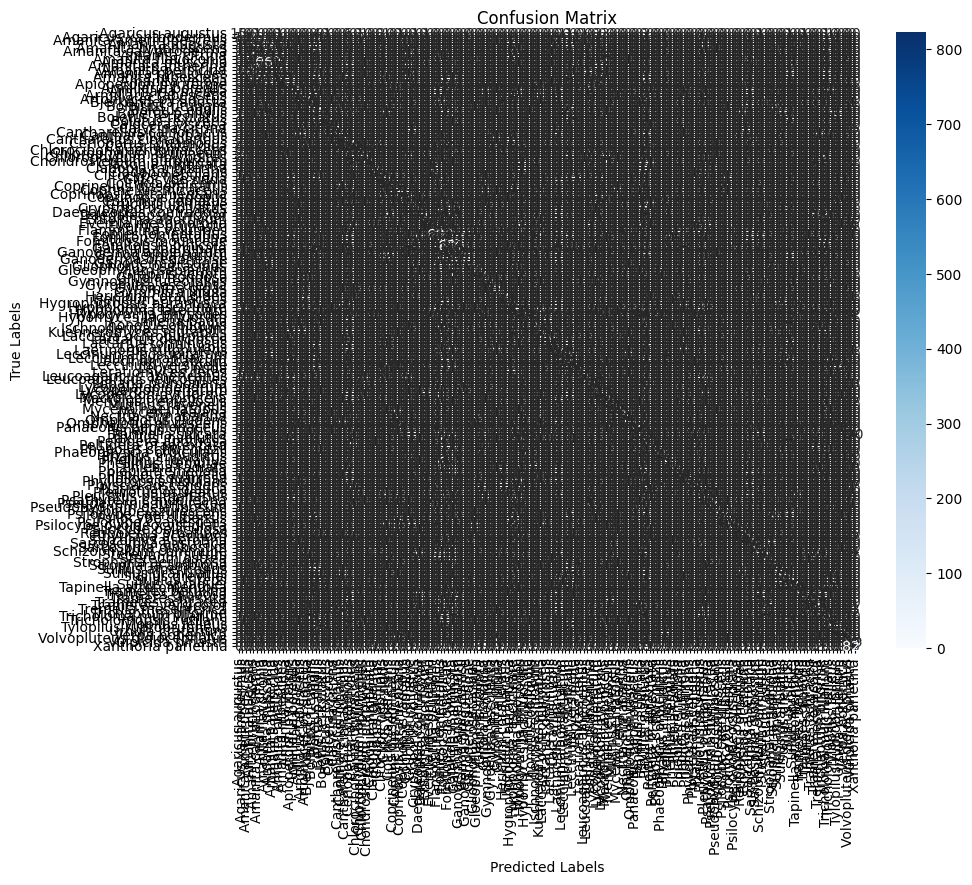

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Optional: get class labels from your generator
class_labels = list(test_gen.class_indices.keys())


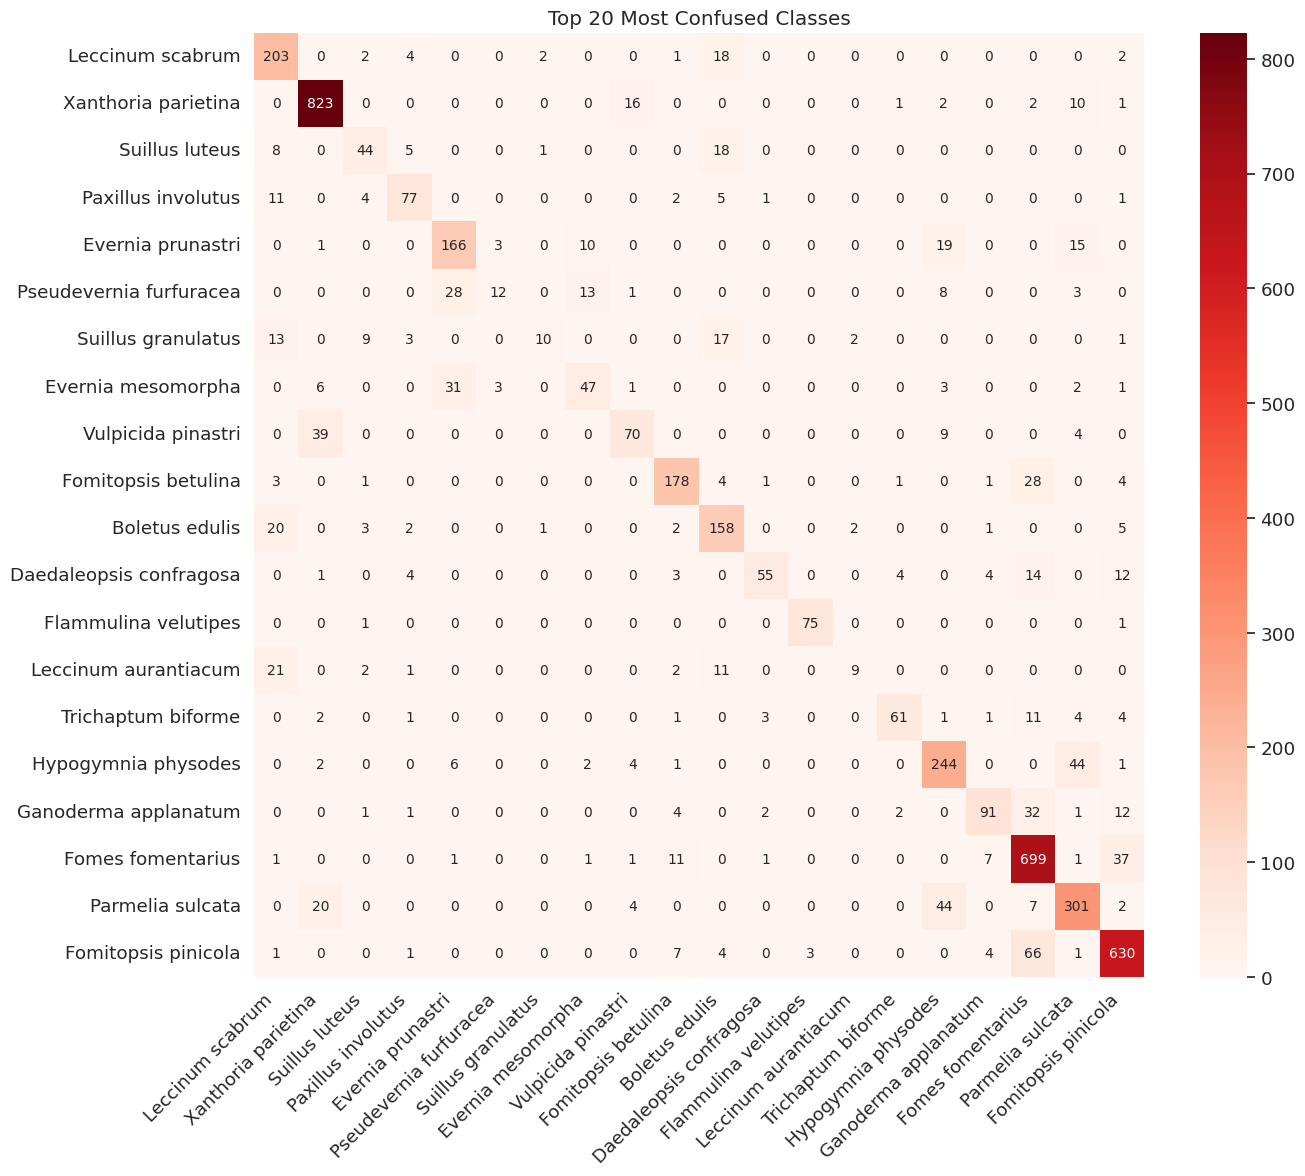

In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Sum of misclassifications per class
misclass_totals = np.sum(cm, axis=1) - np.diag(cm)

# Get indices of top confused classes
top_indices = np.argsort(misclass_totals)[-20:]  # top 20

# Slice matrix and labels
cm_top = cm[np.ix_(top_indices, top_indices)]
labels_top = [class_labels[i] for i in top_indices]

# Plot
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.2)
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels_top, yticklabels=labels_top,
            annot_kws={"size": 10})
plt.title("Top 20 Most Confused Classes")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [56]:
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW


### Transfer Learning: using **EfficientNetV2-B0** as a base model and finetuning deeper layers

In [57]:
#Generators
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_dataframe(
    train_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df_unique,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
# model
base = EfficientNetV2B0(include_top=False, input_shape=(224,224,3), weights="imagenet")
base.trainable = False  # freeze backbone first

model_EfficientNetV2B0_finetuned = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Label smoothing
'''It prevents the network from becoming overconfident.
Improves generalization, especially with small/medium datasets (which is common in mushrooms).
Helps when your labels aren’t perfect (slight mislabels or visually confusing classes).
Works even without augmentation, because it’s a form of “regularization in the loss”.'''
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
'''Instead of a fixed learning rate, we let it decay in a cosine curve, then “restart” to a higher value periodically.
Cosine annealing gives bursts of higher LR that can help it escape shallow minima and improve convergence.
The m_mul=0.8 makes each restart peak a bit lower → so training gradually settles.
'''
# Optimizer + schedule
steps_per_epoch = max(1, train_gen.n // train_gen.batch_size)
# Cosine decay restarts (stable without aug)
lr_schedule_stage1 = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3, first_decay_steps=5 * steps_per_epoch, t_mul=2.0, m_mul=0.8
)


model_EfficientNetV2B0_finetuned.compile(optimizer = Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
cbs = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("mushroom_efficientnetv2b0_best_v5.keras", save_best_only=True, monitor="val_accuracy"),
]


# Phase 1: train head (new layers)
model_EfficientNetV2B0_finetuned.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=cbs, verbose=1)

# phase 2 : finetune layers from the original base model
## unfreeze the last 30% layers

for layer in base.layers:  # freeze earlier layers
    layer.trainable = False
unfreeze_from = int(len(base.layers)*0.7)

for layer in base.layers[unfreeze_from:]:
    layer.trainable = True
# Keep BatchNorms frozen (crucial without augmentation)
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Lower LR for fine-tuning
lr_schedule_stage2 = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-5, first_decay_steps=8 * steps_per_epoch, t_mul=2.0, m_mul=0.9
)



model_EfficientNetV2B0_finetuned.compile(optimizer=AdamW(learning_rate=lr_schedule_stage2, weight_decay=5e-5),
              loss=loss_fn, metrics=["accuracy"])

cbs2 = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    ModelCheckpoint("mushroom_efficientnetv2b0_finetune_best.keras", monitor="val_accuracy", save_best_only=True),
]



Found 72858 validated image filenames belonging to 169 classes.
Found 15616 validated image filenames belonging to 169 classes.
Found 15614 validated image filenames belonging to 169 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 385s 159ms/step - accuracy: 0.2561 - loss: 3.7087 - val_accuracy: 0.5369 - val_loss: 1.8772
Epoch 2/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 343s 151ms/step - accuracy: 0.4780 - loss: 2.1056 - val_accuracy: 0.6285 - val_loss: 1.4350
Epoch 3/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 342s 150ms/step - accuracy: 0.5523 - loss: 1.7269 - val_accuracy: 0.6666 - val_loss: 1.2431
Epoch 4/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 342s 150ms/step - accuracy: 0.5877 - loss: 1.5331 - val_accuracy: 0.6906 - val_loss: 1.1290
Epoch 5/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 342s 150ms/step - accuracy: 0.6147 - loss: 1.4109 - val_accuracy: 0.7080 - val_loss: 1.0636
Epoch 6/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 340s 149ms/step - accuracy: 0.6367 - loss: 1.3183 - val_accuracy: 0.7202 - val_loss: 1.0158
Epoch 7/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 346s 152ms/step - accuracy: 0.6545 - loss: 1.2331 - val_accuracy: 0.7315 - val_loss: 0.9734
Epoch 8/20
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 343s 151ms/step - ac

KeyboardInterrupt: 

In [60]:

history = model_EfficientNetV2B0_finetuned.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=cbs2, verbose=1)

print("Test performance:")
model_EfficientNetV2B0_finetuned.evaluate(test_gen, verbose=1)

model_EfficientNetV2B0_finetuned.save("mushroom_model_EfficientNetV2B0_finetuned.keras")
files.download('mushroom_model_EfficientNetV2B0_finetuned.keras')

Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 346s 152ms/step - accuracy: 0.8243 - loss: 1.5977 - val_accuracy: 0.8068 - val_loss: 1.6001
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 357s 157ms/step - accuracy: 0.8344 - loss: 1.5821 - val_accuracy: 0.8081 - val_loss: 1.5959
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 355s 156ms/step - accuracy: 0.8354 - loss: 1.5703 - val_accuracy: 0.8083 - val_loss: 1.5947
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 354s 156ms/step - accuracy: 0.8304 - loss: 1.5793 - val_accuracy: 0.8078 - val_loss: 1.5896
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 349s 153ms/step - accuracy: 0.8352 - loss: 1.5670 - val_accuracy: 0.8105 - val_loss: 1.5716
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 347s 153ms/step - accuracy: 0.8478 - loss: 1.5277 - val_accuracy: 0.8140 - val_loss: 1.5589
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 345s 152ms/step - accuracy: 0.8512 - loss: 1.5072 - val_accuracy: 0.8147 - val_loss: 1.5476
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 352s 155ms/step - ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
model_EfficientNetV2B0_finetuned.evaluate(test_gen, verbose=1)


488/488 ━━━━━━━━━━━━━━━━━━━━ 62s 128ms/step - accuracy: 0.8142 - loss: 1.5434


[1.5422062873840332, 0.8134366869926453]